In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Preprocessing

In [4]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}) 

In [5]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HF_reg = ds_HF.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

# u_rel Testing

In [7]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='u_relative', batch_size=32, normalization_type='normalization', normalization_stats = True)

Training set size: 510
Validation set size: 109
Testing set size: 111


In [8]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = LR_test.shape[1]
image_width = LR_test.shape[2]
output_channels = 1 

# Instantiate the model with the parameters
model = CNN(in_channels, image_height, image_width, output_channels)
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=59200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=60000, bias=True)
)

In [24]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_norm.pth', 
            n_epochs=50) # n_epochs=2000) # model_CNN_urel_norm

Trainable Parameters: 15341024
Resuming from epoch 50 with best val losses [0.001000356660737152, 0.0010012874866775962, 0.0009957122757449882, 0.0009979207245974775, 0.000977226001116524]
Training complete


In [9]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_norm.pth') # model_CNN_urel_norm
sr_pred

Loaded model parameters from ./model_CNN_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.5794002 , 0.5547783 , 0.5461455 , ..., 0.44035476,
         0.40381372, 0.44320518],
        [0.5848424 , 0.55610275, 0.58099985, ..., 0.42689848,
         0.431412  , 0.4177351 ],
        [0.56587076, 0.5832693 , 0.5491133 , ..., 0.40833738,
         0.41317892, 0.40054452],
        ...,
        [0.6246276 , 0.64621407, 0.6314222 , ..., 0.66902   ,
         0.6586914 , 0.68507725],
        [0.62710226, 0.62644297, 0.6289011 , ..., 0.6664501 ,
         0.6788311 , 0.6791224 ],
        [0.625077  , 0.6215452 , 0.61103565, ..., 0.68048877,
         0.6646169 , 0.6552807 ]],

       [[0.34228066, 0.33792916, 0.34883094, ..., 0.49499735,
         0.485354  , 0.5111675 ],
        [0.35761052, 0.32018   , 0.36046433, ..., 0.51979625,
         0.49480197, 0.52332526],
        [0.35227057, 0.34777543, 0.3455347 , ..., 0.5004058 ,
         0.5152525 , 0.52051246],
...
        [0.6108529 , 0.64793444, 0.62298787, ..., 0.50286734,
         0.4930799 , 0.5104438 ],
        [0.63106704, 0.5901453 , 0.6115892 , ..., 0.51576203,
         0.5032428 , 0.5201592 ],
        [0.60749316, 0.617703  , 0.60968375, ..., 0.50467354,
         0.46525294, 0.49317437]],

       [[0.46277818, 0.4548747 , 0.4373838 , ..., 0.40617254,
         0.41187447, 0.40152806],
        [0.46473438, 0.4787221 , 0.45974526, ..., 0.38824546,
         0.4109213 , 0.38608044],
        [0.44847897, 0.46379122, 0.4449408 , ..., 0.40795404,
         0.402531  , 0.3925323 ],
        ...,
        [0.4353792 , 0.42709598, 0.43624532, ..., 0.3863885 ,
         0.3966023 , 0.38873905],
        [0.4261923 , 0.45577157, 0.43494046, ..., 0.3864601 ,
         0.3880956 , 0.38832948],
        [0.43814167, 0.44007674, 0.4356698 , ..., 0.399234  ,
         0.40958083, 0.39996237]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0182-01-18 12:00:00 ... 0181-08-17 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [10]:
r2_scores_urel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_urel)
best_r2 = r2_scores_urel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9903 at index 78


In [13]:
min_val, max_val = norm_stats
urel_HR_test = HR_test * (max_val - min_val) + min_val
urel_LR_test = LR_test * (max_val - min_val) + min_val
urel_sr_pred = sr_pred * (max_val - min_val) + min_val

# v_rel Testing

In [18]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='v_relative', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [29]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_vrel_norm.pth', 
            n_epochs=50) # n_epochs=2000) 

Trainable Parameters: 15341024
Resuming from epoch 50 with best val losses [0.001460103063903954, 0.0014567608793411369, 0.001429586699061574, 0.0014291662912935428, 0.0014264569820733655]
Training complete


In [19]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_vrel_norm.pth')
sr_pred

Loaded model parameters from ./model_CNN_vrel_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.39005685, 0.39475515, 0.3932618 , ..., 0.47910792,
         0.493604  , 0.47717816],
        [0.39841717, 0.39217255, 0.39962226, ..., 0.48658174,
         0.48337775, 0.49186397],
        [0.39440066, 0.39381397, 0.3963118 , ..., 0.49119338,
         0.49343058, 0.49570823],
        ...,
        [0.45121157, 0.43434227, 0.4390553 , ..., 0.44431436,
         0.4536446 , 0.4412834 ],
        [0.44334036, 0.44763428, 0.44499347, ..., 0.44501865,
         0.44326934, 0.4447147 ],
        [0.4446588 , 0.44230345, 0.4480546 , ..., 0.44374374,
         0.45468536, 0.4542616 ]],

       [[0.4933479 , 0.49341038, 0.50821483, ..., 0.48971844,
         0.4747209 , 0.49592438],
        [0.48777896, 0.47871047, 0.49186268, ..., 0.5030942 ,
         0.48617905, 0.49774104],
        [0.50962085, 0.49382457, 0.50302416, ..., 0.4764993 ,
         0.48883075, 0.49346977],
...
        [0.56401193, 0.5519036 , 0.5572792 , ..., 0.6036053 ,
         0.6054942 , 0.60397583],
        [0.55688447, 0.56458855, 0.5640591 , ..., 0.6001379 ,
         0.61075145, 0.60478795],
        [0.5629853 , 0.55577874, 0.5600665 , ..., 0.6098299 ,
         0.61869174, 0.60599923]],

       [[0.3646681 , 0.36459783, 0.37607223, ..., 0.6113072 ,
         0.6044216 , 0.6192872 ],
        [0.36610803, 0.34801117, 0.3689692 , ..., 0.6270837 ,
         0.6115687 , 0.6242047 ],
        [0.38091108, 0.365113  , 0.3712282 , ..., 0.6089628 ,
         0.62359035, 0.626086  ],
        ...,
        [0.528648  , 0.54165995, 0.534598  , ..., 0.63183403,
         0.6308218 , 0.637569  ],
        [0.53055423, 0.52331555, 0.5271599 , ..., 0.63945526,
         0.6216719 , 0.63367563],
        [0.5184782 , 0.5295283 , 0.52541566, ..., 0.63115364,
         0.61371124, 0.6265049 ]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0182-10-15 12:00:00 ... 0181-05-04 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [20]:
r2_scores_vrel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_vrel)
best_r2 = r2_scores_vrel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9843 at index 43


In [21]:
min_val, max_val = norm_stats
vrel_HR_test = HR_test * (max_val - min_val) + min_val
vrel_LR_test = LR_test * (max_val - min_val) + min_val
vrel_sr_pred = sr_pred * (max_val - min_val) + min_val

# t_ref Testing

In [22]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='t_ref', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [34]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_tref_norm.pth', 
            n_epochs=50) # n_epochs=2000) 

Trainable Parameters: 15341024
Resuming from epoch 15 with best val losses []
Epoch 16, Train Loss: 2.195e-04, Val Loss: 1.984e-04, Epoch Time: 30.49s
Model saved at epoch 16
Epoch 17, Train Loss: 2.170e-04, Val Loss: 1.954e-04, Epoch Time: 11.94s
Model saved at epoch 17
Epoch 18, Train Loss: 2.143e-04, Val Loss: 1.983e-04, Epoch Time: 9.59s
Model saved at epoch 18
Epoch 19, Train Loss: 2.144e-04, Val Loss: 1.916e-04, Epoch Time: 9.19s
Model saved at epoch 19
Epoch 20, Train Loss: 2.102e-04, Val Loss: 1.942e-04, Epoch Time: 9.30s
Model saved at epoch 20
Epoch 21, Train Loss: 2.085e-04, Val Loss: 1.915e-04, Epoch Time: 9.49s
Model saved at epoch 21
Epoch 22, Train Loss: 2.068e-04, Val Loss: 1.913e-04, Epoch Time: 9.58s
Model saved at epoch 22
Epoch 23, Train Loss: 2.057e-04, Val Loss: 1.919e-04, Epoch Time: 9.14s
Model saved at epoch 23
Epoch 24, Train Loss: 2.040e-04, Val Loss: 1.880e-04, Epoch Time: 9.29s
Model saved at epoch 24
Epoch 25, Train Loss: 2.035e-04, Val Loss: 1.876e-04, Ep

In [23]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_tref_norm.pth')
sr_pred

Loaded model parameters from ./model_CNN_tref_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.94420016, 0.94274586, 0.94716156, ..., 0.85060614,
         0.84303874, 0.8511141 ],
        [0.939082  , 0.9370795 , 0.93988454, ..., 0.85291827,
         0.8472417 , 0.84887743],
        [0.94404966, 0.93947387, 0.9415091 , ..., 0.83995336,
         0.8438388 , 0.8442434 ],
        ...,
        [0.32722014, 0.33637777, 0.33149856, ..., 0.39814427,
         0.39413235, 0.4008184 ],
        [0.32907093, 0.31741917, 0.32394353, ..., 0.39787862,
         0.3928845 , 0.39754152],
        [0.3206368 , 0.3232221 , 0.32067734, ..., 0.39164874,
         0.38250425, 0.3902917 ]],

       [[0.90839297, 0.9071453 , 0.9040262 , ..., 0.8786095 ,
         0.8789975 , 0.87570465],
        [0.90880716, 0.9068709 , 0.90866387, ..., 0.87585044,
         0.8773155 , 0.874851  ],
        [0.900736  , 0.90575093, 0.9019787 , ..., 0.877816  ,
         0.8753903 , 0.8733541 ],
...
        [0.21415353, 0.21274853, 0.21453206, ..., 0.21348473,
         0.21688809, 0.21365428],
        [0.21377392, 0.2189746 , 0.21763265, ..., 0.20969266,
         0.21744359, 0.21444942],
        [0.21773499, 0.21617718, 0.21697098, ..., 0.21624896,
         0.22179666, 0.21555856]],

       [[0.7649939 , 0.7656467 , 0.7627535 , ..., 0.7784441 ,
         0.77841556, 0.77329344],
        [0.7598689 , 0.76698244, 0.7616542 , ..., 0.77321947,
         0.77601045, 0.7730222 ],
        [0.7508223 , 0.7582258 , 0.7573069 , ..., 0.77584046,
         0.7707385 , 0.77003694],
        ...,
        [0.0805577 , 0.07300303, 0.07777993, ..., 0.2601726 ,
         0.2606463 , 0.2601628 ],
        [0.07755923, 0.07638986, 0.0788566 , ..., 0.25525218,
         0.26318407, 0.2581318 ],
        [0.08028204, 0.07541914, 0.07855418, ..., 0.25758502,
         0.26256484, 0.2593317 ]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0181-10-31 12:00:00 ... 0181-01-29 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [24]:
r2_scores_tref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_tref)
best_r2 = r2_scores_tref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9976 at index 53


In [25]:
min_val, max_val = norm_stats
tref_HR_test = HR_test * (max_val - min_val) + min_val
tref_LR_test = LR_test * (max_val - min_val) + min_val
tref_sr_pred = sr_pred * (max_val - min_val) + min_val

# q_ref Testing

In [26]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='q_ref', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [39]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_qref_norm.pth', 
            n_epochs=50) # n_epochs=2000) 

Trainable Parameters: 15341024
Epoch 1, Train Loss: 2.682e-03, Val Loss: 1.311e-03, Epoch Time: 9.46s
Model saved at epoch 1
Epoch 2, Train Loss: 1.162e-03, Val Loss: 1.012e-03, Epoch Time: 9.83s
Model saved at epoch 2
Epoch 3, Train Loss: 9.104e-04, Val Loss: 8.775e-04, Epoch Time: 9.47s
Model saved at epoch 3
Epoch 4, Train Loss: 8.356e-04, Val Loss: 8.240e-04, Epoch Time: 9.58s
Model saved at epoch 4
Epoch 5, Train Loss: 8.096e-04, Val Loss: 8.074e-04, Epoch Time: 9.67s
Model saved at epoch 5
Epoch 6, Train Loss: 7.936e-04, Val Loss: 7.946e-04, Epoch Time: 9.49s
Model saved at epoch 6
Epoch 7, Train Loss: 7.821e-04, Val Loss: 8.012e-04, Epoch Time: 9.55s
Model saved at epoch 7
Epoch 8, Train Loss: 7.759e-04, Val Loss: 7.884e-04, Epoch Time: 9.47s
Model saved at epoch 8
Epoch 9, Train Loss: 7.745e-04, Val Loss: 7.729e-04, Epoch Time: 9.28s
Model saved at epoch 9
Epoch 10, Train Loss: 7.593e-04, Val Loss: 7.656e-04, Epoch Time: 9.29s
Model saved at epoch 10
Epoch 11, Train Loss: 7.539

In [27]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_qref_norm.pth')
sr_pred

Loaded model parameters from ./model_CNN_qref_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.3662787 , 0.36890647, 0.37088552, ..., 0.45333368,
         0.4622392 , 0.452142  ],
        [0.3681612 , 0.36870337, 0.35936472, ..., 0.45569453,
         0.45807618, 0.4504329 ],
        [0.3666113 , 0.3631047 , 0.36496964, ..., 0.44968385,
         0.45671874, 0.4477825 ],
        ...,
        [0.05310024, 0.05125494, 0.05001359, ..., 0.10418488,
         0.10605463, 0.09539766],
        [0.04667521, 0.05783821, 0.05034871, ..., 0.10103419,
         0.09250548, 0.09852965],
        [0.04559775, 0.04480345, 0.04690775, ..., 0.09235948,
         0.10129169, 0.10056287]],

       [[0.53572273, 0.5391059 , 0.5426826 , ..., 0.5201437 ,
         0.5274473 , 0.51852584],
        [0.5363817 , 0.5385835 , 0.5301465 , ..., 0.52264524,
         0.5240525 , 0.5157796 ],
        [0.5384495 , 0.53327155, 0.5369532 , ..., 0.51711375,
         0.5236234 , 0.5151352 ],
...
        [0.17986271, 0.1760492 , 0.17701621, ..., 0.21076822,
         0.2119008 , 0.20479265],
        [0.17460164, 0.17958017, 0.17652804, ..., 0.20843595,
         0.20332733, 0.20601511],
        [0.17350994, 0.17210034, 0.17449576, ..., 0.20198214,
         0.20847419, 0.20821954]],

       [[0.85121536, 0.8506111 , 0.85511637, ..., 0.76652   ,
         0.76784915, 0.7674396 ],
        [0.86309034, 0.84758914, 0.85132635, ..., 0.7726582 ,
         0.76982427, 0.7618392 ],
        [0.86218745, 0.857503  , 0.854825  , ..., 0.76211655,
         0.77314895, 0.7585057 ],
        ...,
        [0.31110558, 0.31642354, 0.3107105 , ..., 0.45940197,
         0.46005684, 0.44944915],
        [0.3058049 , 0.32024154, 0.31376702, ..., 0.4546185 ,
         0.4456796 , 0.45324904],
        [0.3039965 , 0.30405402, 0.30632293, ..., 0.445093  ,
         0.45314285, 0.4501205 ]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0182-02-25 12:00:00 ... 0181-08-27 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [28]:
r2_scores_qref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_qref)
best_r2 = r2_scores_qref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9939 at index 19


In [29]:
min_val, max_val = norm_stats
qref_HR_test = HR_test * (max_val - min_val) + min_val
qref_LR_test = LR_test * (max_val - min_val) + min_val
qref_sr_pred = sr_pred * (max_val - min_val) + min_val

# SLP Testing

In [30]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='slp', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [44]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_slp_norm.pth', 
            n_epochs=50) # n_epochs=2000) 

Trainable Parameters: 15341024
Epoch 1, Train Loss: 1.777e-02, Val Loss: 4.793e-03, Epoch Time: 9.25s
Model saved at epoch 1
Epoch 2, Train Loss: 3.962e-03, Val Loss: 1.755e-03, Epoch Time: 9.05s
Model saved at epoch 2
Epoch 3, Train Loss: 1.318e-03, Val Loss: 6.617e-04, Epoch Time: 9.07s
Model saved at epoch 3
Epoch 4, Train Loss: 7.688e-04, Val Loss: 5.535e-04, Epoch Time: 9.09s
Model saved at epoch 4
Epoch 5, Train Loss: 6.224e-04, Val Loss: 4.843e-04, Epoch Time: 9.75s
Model saved at epoch 5
Epoch 6, Train Loss: 5.474e-04, Val Loss: 4.314e-04, Epoch Time: 9.28s
Model saved at epoch 6
Epoch 7, Train Loss: 4.874e-04, Val Loss: 3.785e-04, Epoch Time: 8.99s
Model saved at epoch 7
Epoch 8, Train Loss: 4.385e-04, Val Loss: 3.545e-04, Epoch Time: 9.10s
Model saved at epoch 8
Epoch 9, Train Loss: 3.966e-04, Val Loss: 3.168e-04, Epoch Time: 9.02s
Model saved at epoch 9
Epoch 10, Train Loss: 3.571e-04, Val Loss: 3.038e-04, Epoch Time: 9.08s
Model saved at epoch 10
Epoch 11, Train Loss: 3.264

In [31]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_slp_norm.pth')
sr_pred

Loaded model parameters from ./model_CNN_slp_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.705551  , 0.70422953, 0.7037023 , ..., 0.6694526 ,
         0.6712119 , 0.67425156],
        [0.7117845 , 0.7022544 , 0.7093944 , ..., 0.6677108 ,
         0.6707355 , 0.6675068 ],
        [0.7098706 , 0.7089859 , 0.7052275 , ..., 0.6742862 ,
         0.6758107 , 0.67122567],
        ...,
        [0.32147482, 0.32906276, 0.3235776 , ..., 0.30706158,
         0.31181654, 0.3045896 ],
        [0.32190233, 0.33294868, 0.32321212, ..., 0.3062436 ,
         0.30020785, 0.30944332],
        [0.32114083, 0.32515535, 0.32083866, ..., 0.3049122 ,
         0.31153944, 0.30889142]],

       [[0.7236233 , 0.72239244, 0.72041726, ..., 0.69482523,
         0.69039094, 0.69500417],
        [0.71555924, 0.7219166 , 0.7233515 , ..., 0.691407  ,
         0.6904402 , 0.69721335],
        [0.71988094, 0.7192538 , 0.7205062 , ..., 0.6952225 ,
         0.6888612 , 0.69892883],
...
        [0.84984595, 0.85024613, 0.85045075, ..., 0.8166223 ,
         0.81589454, 0.8092853 ],
        [0.84776515, 0.8511757 , 0.8507988 , ..., 0.8120817 ,
         0.8115214 , 0.8114273 ],
        [0.84695274, 0.84631187, 0.8485901 , ..., 0.8093864 ,
         0.81623995, 0.81051403]],

       [[0.7170762 , 0.7159278 , 0.71462697, ..., 0.72293836,
         0.7212783 , 0.72433174],
        [0.715189  , 0.71558034, 0.7187024 , ..., 0.72119594,
         0.7218741 , 0.7241246 ],
        [0.71788216, 0.7169472 , 0.7164465 , ..., 0.72680646,
         0.7236399 , 0.72709   ],
        ...,
        [0.6039776 , 0.607582  , 0.60869277, ..., 0.7602227 ,
         0.76134646, 0.76337534],
        [0.6066499 , 0.60561496, 0.6074857 , ..., 0.76061225,
         0.7628288 , 0.76239043],
        [0.6065773 , 0.6095662 , 0.60864425, ..., 0.7632836 ,
         0.7617329 , 0.7612993 ]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0181-01-23 12:00:00 ... 0181-07-07 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [32]:
r2_scores_slp = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_slp)
best_r2 = r2_scores_slp[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9977 at index 35


In [33]:
min_val, max_val = norm_stats
slp_HR_test = HR_test * (max_val - min_val) + min_val
slp_LR_test = LR_test * (max_val - min_val) + min_val
slp_sr_pred = sr_pred * (max_val - min_val) + min_val

# SST Testing

In [34]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='surface_temp', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [49]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses = train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_sst_norm.pth', 
            n_epochs=50) # n_epochs=2000) 

Trainable Parameters: 15341024
Epoch 1, Train Loss: 4.573e-03, Val Loss: 1.163e-03, Epoch Time: 9.29s
Model saved at epoch 1
Epoch 2, Train Loss: 1.200e-03, Val Loss: 7.806e-04, Epoch Time: 9.37s
Model saved at epoch 2
Epoch 3, Train Loss: 5.987e-04, Val Loss: 4.686e-04, Epoch Time: 9.24s
Model saved at epoch 3
Epoch 4, Train Loss: 4.200e-04, Val Loss: 3.709e-04, Epoch Time: 9.28s
Model saved at epoch 4
Epoch 5, Train Loss: 3.571e-04, Val Loss: 3.282e-04, Epoch Time: 9.41s
Model saved at epoch 5
Epoch 6, Train Loss: 3.283e-04, Val Loss: 3.145e-04, Epoch Time: 9.53s
Model saved at epoch 6
Epoch 7, Train Loss: 3.156e-04, Val Loss: 3.041e-04, Epoch Time: 9.16s
Model saved at epoch 7
Epoch 8, Train Loss: 3.061e-04, Val Loss: 2.976e-04, Epoch Time: 9.16s
Model saved at epoch 8
Epoch 9, Train Loss: 3.017e-04, Val Loss: 2.954e-04, Epoch Time: 9.28s
Model saved at epoch 9
Epoch 10, Train Loss: 2.973e-04, Val Loss: 2.868e-04, Epoch Time: 9.32s
Model saved at epoch 10
Epoch 11, Train Loss: 2.941

In [35]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_sst_norm.pth')
sr_pred

Loaded model parameters from ./model_CNN_sst_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[ 7.55800009e-01,  7.58080423e-01,  7.56334662e-01, ...,
          7.48889923e-01,  7.46855795e-01,  7.45672107e-01],
        [ 7.46999383e-01,  7.50939965e-01,  7.50750661e-01, ...,
          7.47511625e-01,  7.46414244e-01,  7.47330070e-01],
        [ 7.37648666e-01,  7.41193116e-01,  7.44876504e-01, ...,
          7.46616721e-01,  7.45402336e-01,  7.46298313e-01],
        ...,
        [ 2.33632326e-03, -1.90434232e-03, -5.97424805e-04, ...,
          1.02232821e-01,  1.00511856e-01,  1.02880560e-01],
        [ 1.01641193e-03, -3.54980491e-03, -7.54632056e-05, ...,
          9.99042690e-02,  1.02778964e-01,  1.00455455e-01],
        [ 9.22579318e-04, -3.41774151e-03, -1.93231553e-03, ...,
          9.95489210e-02,  9.87761989e-02,  9.92522240e-02]],

       [[ 7.32918620e-01,  7.34771311e-01,  7.34758139e-01, ...,
          7.23410606e-01,  7.24537611e-01,  7.22963393e-01],
        [ 7.26372600e-01,  7.29151368e-01,  7.26909518e-01, ...,
          7.22508967e-01,  7.23193407e-01,  7.20278859e-01],
        [ 7.24111736e-01,  7.21358180e-01,  7.25154996e-01, ...,
          7.23433018e-01,  7.24488616e-01,  7.22914100e-01],
...
          6.42943010e-02,  6.58432320e-02,  6.30637631e-02],
        [ 3.01435217e-02,  3.46249491e-02,  2.97477581e-02, ...,
          6.37214035e-02,  5.88392392e-02,  6.25830516e-02],
        [ 2.88270395e-02,  3.35403830e-02,  3.02034840e-02, ...,
          5.96585572e-02,  6.02632985e-02,  6.27506971e-02]],

       [[ 9.20976639e-01,  9.18822527e-01,  9.18815434e-01, ...,
          8.68334889e-01,  8.67225766e-01,  8.68651927e-01],
        [ 9.22419071e-01,  9.13966775e-01,  9.20080543e-01, ...,
          8.67877126e-01,  8.67223680e-01,  8.65264356e-01],
        [ 9.15637851e-01,  9.16573286e-01,  9.13734674e-01, ...,
          8.69239450e-01,  8.70700538e-01,  8.65843296e-01],
        ...,
        [ 1.40792787e-01,  1.44874185e-01,  1.41206011e-01, ...,
          2.17063516e-01,  2.17817932e-01,  2.14768112e-01],
        [ 1.39144599e-01,  1.45208284e-01,  1.40235484e-01, ...,
          2.14304775e-01,  2.14194447e-01,  2.16050208e-01],
        [ 1.37220919e-01,  1.38679728e-01,  1.36177316e-01, ...,
          2.12142721e-01,  2.16427833e-01,  2.14175493e-01]]],
      shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0181-02-17 12:00:00 ... 0182-11-02 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [36]:
r2_scores_sst = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_sst)
best_r2 = r2_scores_sst[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9971 at index 10


In [37]:
min_val, max_val = norm_stats
sst_HR_test = HR_test * (max_val - min_val) + min_val
sst_LR_test = LR_test * (max_val - min_val) + min_val
sst_sr_pred = sr_pred * (max_val - min_val) + min_val

# Figures

In [38]:
# Suppose you have 6 arrays: a1, a2, ..., a6 (all same length)
arrays = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

# Stack into shape (6, N) and take mean over axis=0
mean_array = np.mean(np.stack(arrays, axis=0), axis=0)

# Find the max value and its index
max_val = np.max(mean_array)
max_idx = np.argmax(mean_array)

print(f"Max value = {max_val}, at index = {max_idx}")

Max value = 0.9838611086209615, at index = 39


In [39]:
# Find the min value and its index
min_val = np.min(mean_array)
min_idx = np.argmin(mean_array)

print(f"Min value = {min_val}, at index = {min_idx}")

Min value = 0.7859828074773153, at index = 100


In [42]:
# Make a Dataset
ds_cnn_norm = xr.Dataset()

# Manually add variables
ds_cnn_norm["u_rel_sr"] = (("time", "y", "x"), urel_sr_pred.values)
ds_cnn_norm["v_rel_sr"] = (("time", "y", "x"), vrel_sr_pred.values)
ds_cnn_norm["t_ref_sr"] = (("time", "y", "x"), tref_sr_pred.values)
ds_cnn_norm["q_ref_sr"] = (("time", "y", "x"), qref_sr_pred.values)
ds_cnn_norm["slp_sr"] = (("time", "y", "x"), slp_sr_pred.values)
ds_cnn_norm["sst_sr"] = (("time", "y", "x"), sst_sr_pred.values)

ds_cnn_norm["u_rel_hr"] = (("time", "y", "x"), urel_HR_test.values)
ds_cnn_norm["v_rel_hr"] = (("time", "y", "x"), vrel_HR_test.values)
ds_cnn_norm["t_ref_hr"] = (("time", "y", "x"), tref_HR_test.values)
ds_cnn_norm["q_ref_hr"] = (("time", "y", "x"), qref_HR_test.values)
ds_cnn_norm["slp_hr"] = (("time", "y", "x"), slp_HR_test.values)
ds_cnn_norm["sst_hr"] = (("time", "y", "x"), sst_HR_test.values)

ds_cnn_norm["u_rel_lr"] = (("time", "y", "x"), urel_LR_test)
ds_cnn_norm["v_rel_lr"] = (("time", "y", "x"), vrel_LR_test)
ds_cnn_norm["t_ref_lr"] = (("time", "y", "x"), tref_LR_test)
ds_cnn_norm["q_ref_lr"] = (("time", "y", "x"), qref_LR_test)
ds_cnn_norm["slp_lr"] = (("time", "y", "x"), slp_LR_test)
ds_cnn_norm["sst_lr"] = (("time", "y", "x"), sst_LR_test)

print(ds_cnn_norm)

<xarray.Dataset> Size: 480MB
Dimensions:   (time: 111, y: 300, x: 200)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    u_rel_sr  (time, y, x) float32 27MB 2.638 1.521 1.129 ... -5.066 -5.502
    v_rel_sr  (time, y, x) float32 27MB -4.625 -4.444 -4.501 ... 4.004 4.498
    t_ref_sr  (time, y, x) float32 27MB 297.3 297.2 297.4 ... 276.9 277.1 277.0
    q_ref_sr  (time, y, x) float32 27MB 0.007955 0.008 ... 0.009426 0.009375
    slp_sr    (time, y, x) float32 27MB 1.018e+05 1.018e+05 ... 1.023e+05
    sst_sr    (time, y, x) float32 27MB 294.4 294.5 294.5 ... 280.7 280.8 280.7
    ...        ...
    u_rel_lr  (time, y, x) float32 27MB 2.306 2.321 2.335 ... -4.731 -4.648
    v_rel_lr  (time, y, x) float32 27MB -4.085 -4.132 -4.177 ... 3.933 3.854
    t_ref_lr  (time, y, x) float32 27MB 297.3 297.3 297.2 ... 277.7 277.7 277.7
    q_ref_lr  (time, y, x) float32 27MB 0.007215 0.007211 ... 0.009558 0.009563
    slp_lr    (time, y, x) float32 27MB 1.017e+05 1.017e+05 ... 1.

In [44]:
ds_cnn_norm.to_zarr("gs://leap-persistent/panalluri/cnn_norm_fluxInputs_all.zarr", zarr_version=2)

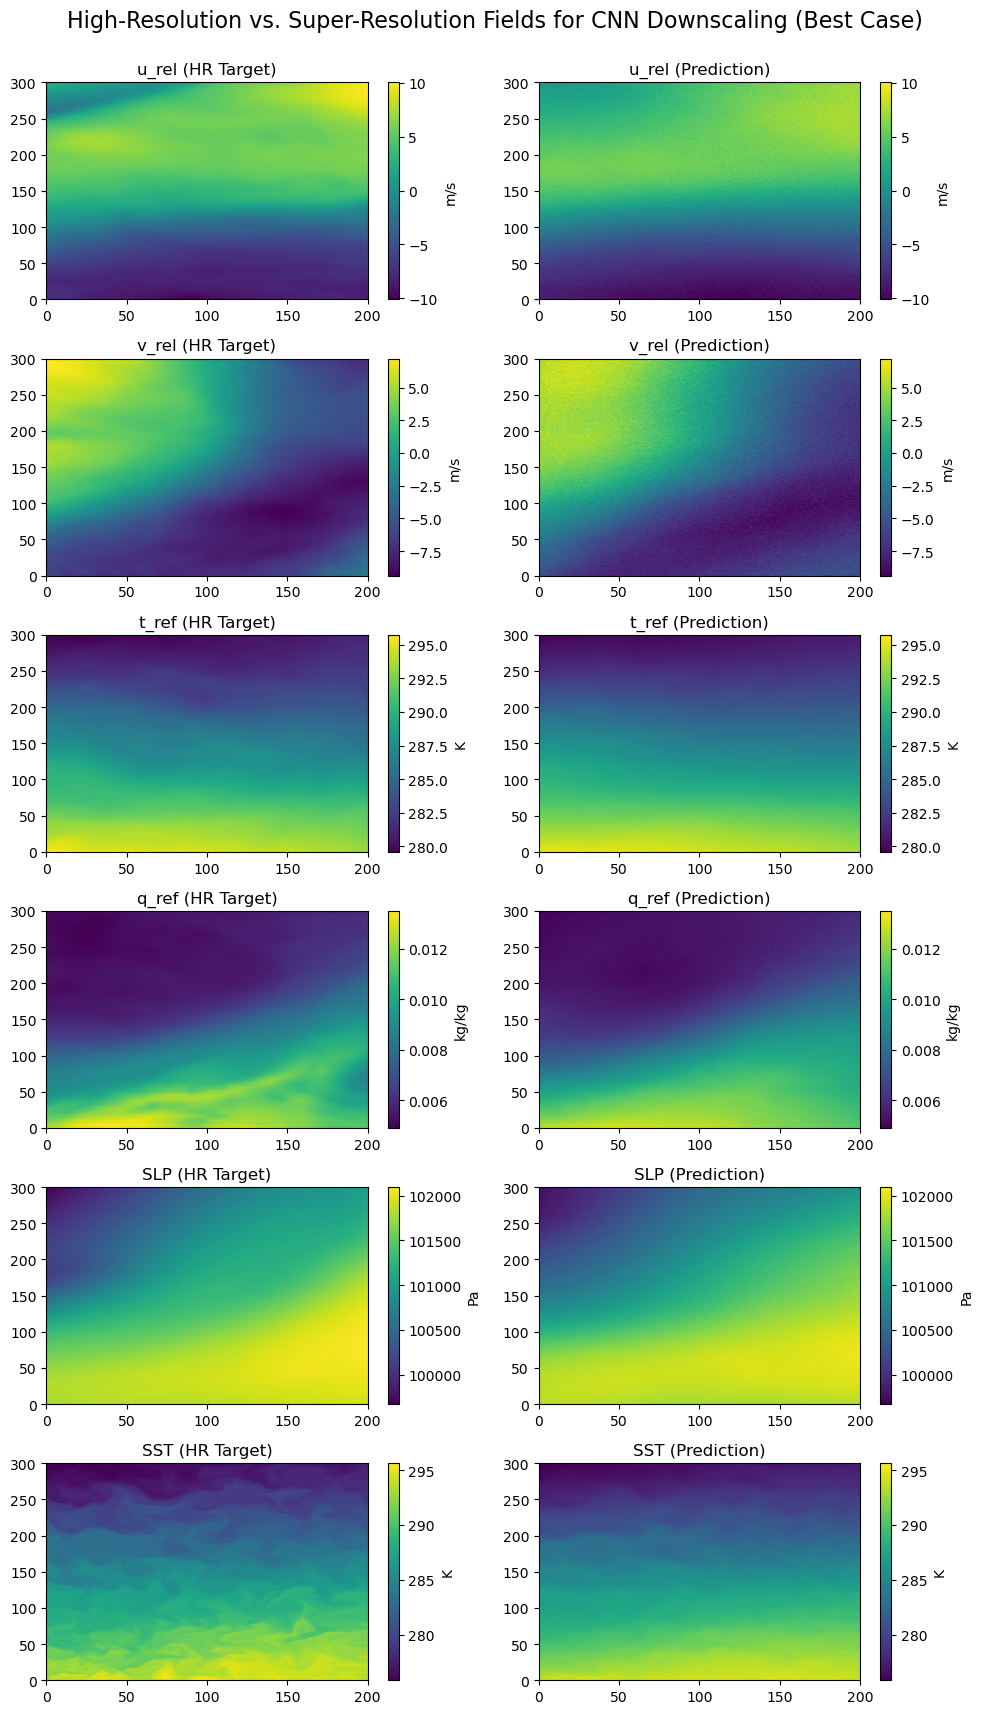

In [47]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[max_idx].min().values, vrel_HR_test[max_idx].min().values, tref_HR_test[max_idx].min().values,
         qref_HR_test[max_idx].min().values, slp_HR_test[max_idx].min().values, sst_HR_test[max_idx].min().values]
vmaxs = [urel_HR_test[max_idx].max().values, vrel_HR_test[max_idx].max().values, tref_HR_test[max_idx].max().values,
         qref_HR_test[max_idx].max().values, slp_HR_test[max_idx].max().values, sst_HR_test[max_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for CNN Downscaling (Best Case)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

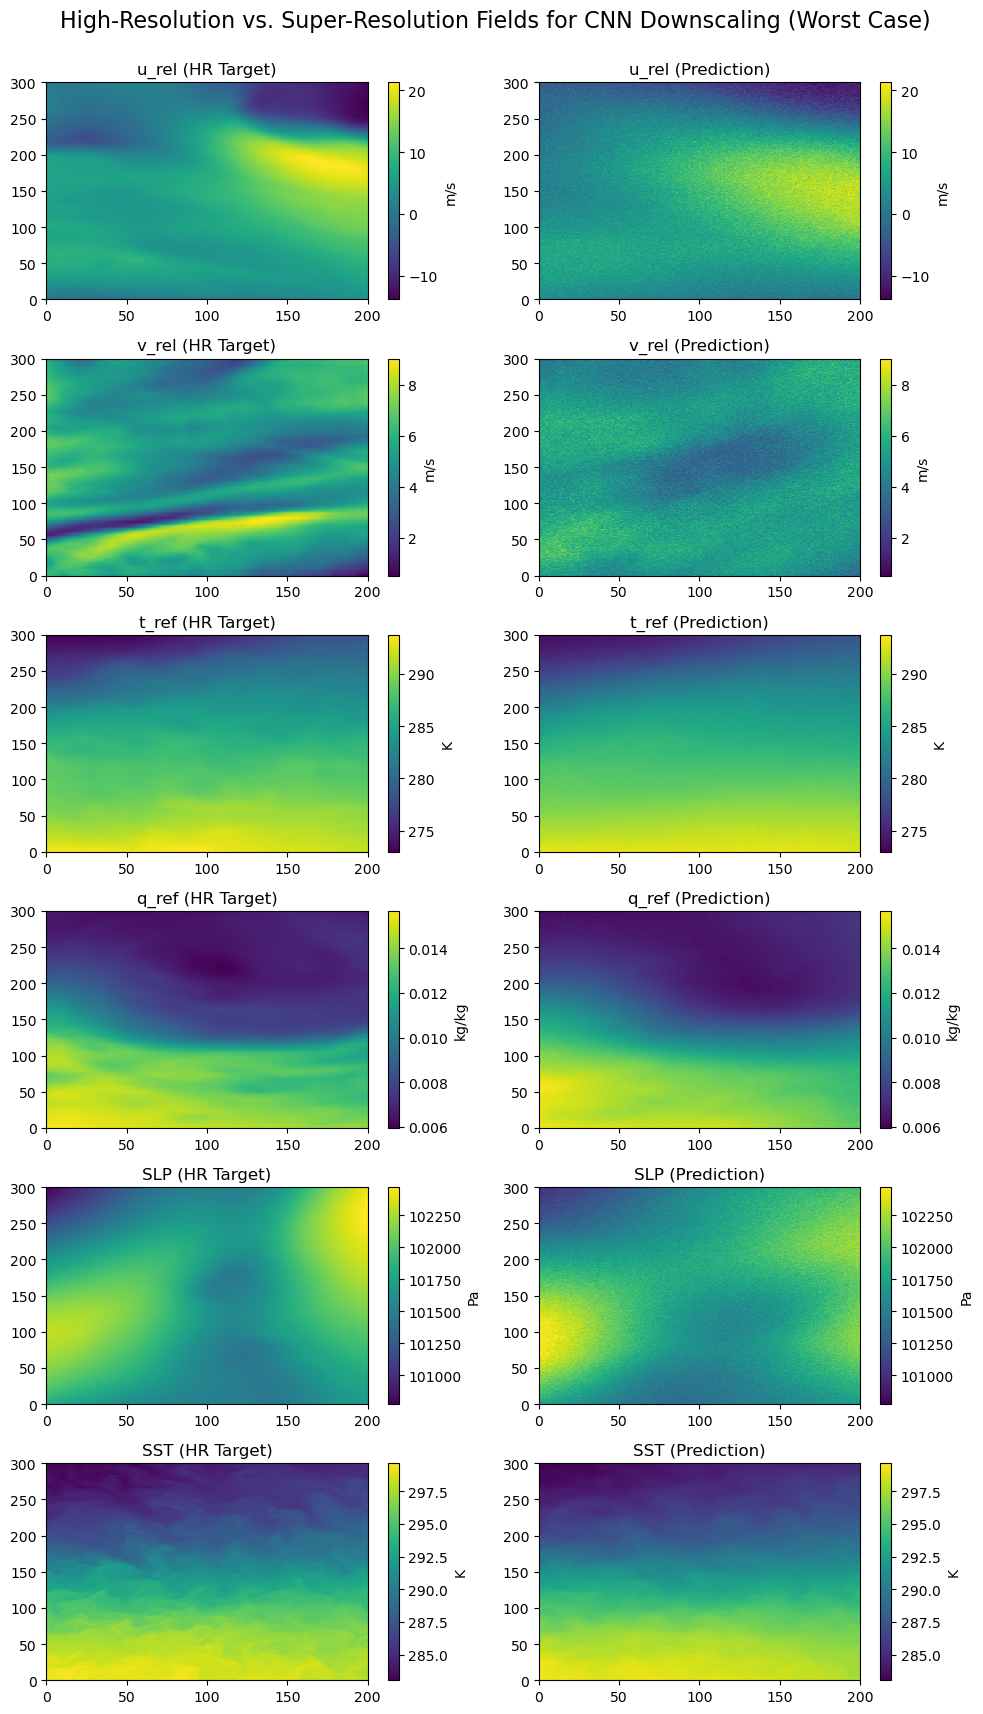

In [48]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[min_idx].min().values, vrel_HR_test[min_idx].min().values, tref_HR_test[min_idx].min().values,
         qref_HR_test[min_idx].min().values, slp_HR_test[min_idx].min().values, sst_HR_test[min_idx].min().values]
vmaxs = [urel_HR_test[min_idx].max().values, vrel_HR_test[min_idx].max().values, tref_HR_test[min_idx].max().values,
         qref_HR_test[min_idx].max().values, slp_HR_test[min_idx].max().values, sst_HR_test[min_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for CNN Downscaling (Worst Case)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# SGS HF Contribution Plots

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import aerobulk
from aerobulk import noskin

In [22]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

In [50]:
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)       # residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # total sum of squares
    return 1 - ss_res / ss_tot

## Import data

In [5]:
ds_all = xr.open_dataset(
"gs://leap-persistent/panalluri/cnn_norm_fluxInputs_all.zarr", engine="zarr", chunks={}
)
ds_all

<xarray.Dataset>
Dimensions:   (time: 111, y: 300, x: 200)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    q_ref_hr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    q_ref_lr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    q_ref_sr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    slp_hr    (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    slp_lr    (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    slp_sr    (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    ...        ...
    u_rel_hr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    u_rel_lr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    u_rel_sr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    v_rel_hr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    v_rel_lr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    v_rel_sr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>

## Stats for all samples

In [60]:
ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_sr,
        ds_all.t_ref_sr,
        ds_all.q_ref_sr,
        ds_all.u_rel_sr,
        ds_all.v_rel_sr,
        slp=ds_all.slp_sr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_sr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_lr,
        ds_all.t_ref_lr,
        ds_all.q_ref_lr,
        ds_all.u_rel_lr,
        ds_all.v_rel_lr,
        slp=ds_all.slp_lr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_lr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_hr,
        ds_all.t_ref_hr,
        ds_all.q_ref_hr,
        ds_all.u_rel_hr,
        ds_all.v_rel_hr,
        slp=ds_all.slp_hr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_hr_all = qh + ql

In [61]:
# Make a Dataset
ds_heatflux = xr.Dataset()

# Manually add variables
ds_heatflux["heatflux_hr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_lr_all.values)
ds_heatflux["heatflux_lr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_hr_all.values)
ds_heatflux["heatflux_sr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_sr_all.values)

ds_heatflux

<xarray.Dataset>
Dimensions:      (time: 111, yt_ocean: 300, xt_ocean: 200)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -90.93 -92.74 ... 58.75
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -132.9 -142.1 ... 64.92
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -106.9 -91.39 ... 49.51 52.9

In [62]:
print("Filtering model")
heatflux_smooth = filter_inputs_dataset(ds_heatflux, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
heatflux_smooth

Filtering model


<xarray.Dataset>
Dimensions:      (time: 111, yt_ocean: 300, xt_ocean: 200)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -72.25 -71.36 ... -58.1
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -81.57 -80.55 ... -60.89
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -50.69 -50.5 ... -66.53
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [63]:
HF_SGS_all_pred = heatflux_smooth.heatflux_sr - heatflux_smooth.heatflux_lr
HF_SGS_all_true = heatflux_smooth.heatflux_hr - heatflux_smooth.heatflux_lr

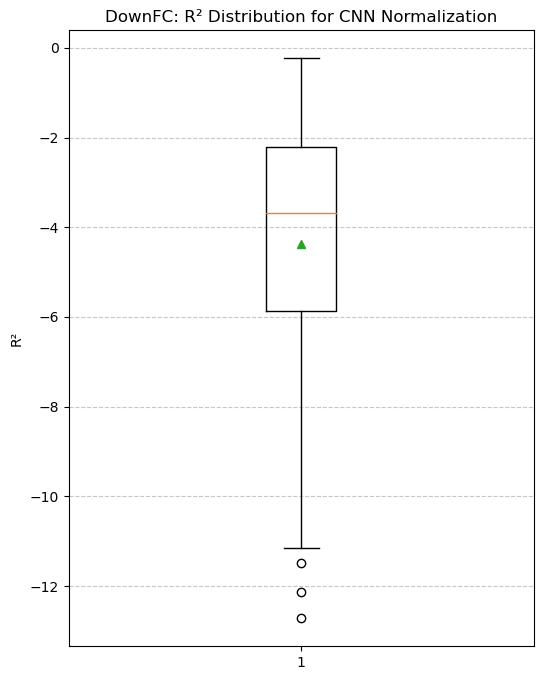

In [64]:
r2_all = r2_per_sample(HF_SGS_all_true.values, HF_SGS_all_pred.values)
plt.figure(figsize=(6, 8))
plt.boxplot(r2_all, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DownFC: R² Distribution for CNN Normalization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Best case results (from SGS HF R2 values)

In [65]:
arr = r2_all

max_val = arr.max()        # get the minimum value
max_idx = arr.argmax()     # get the index of the minimum value

print("Maximum R2 value:", max_val)
print("Index of maximum:", max_idx)

Maximum R2 value: -0.2328277408913475
Index of maximum: 89


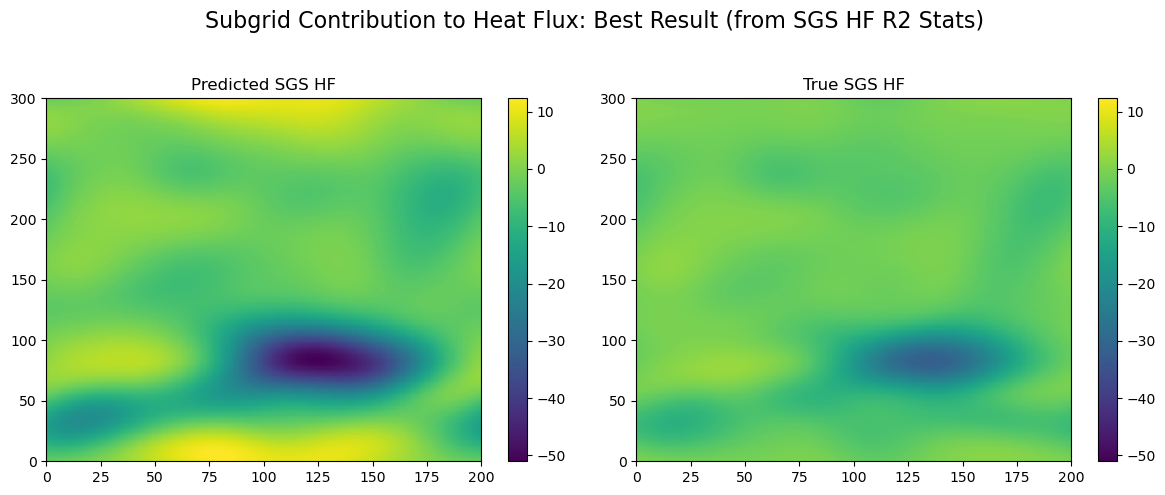

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx)
data2 = HF_SGS_all_true.isel(time=max_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Worst case results (from SGS HF R2 values)

In [69]:
arr = r2_all

min_val = arr.min()        # get the minimum value
min_idx = arr.argmin()     # get the index of the minimum value

print("Minimum R2 value:", min_val)
print("Index of minimum:", min_idx)

Minimum R2 value: -12.71939072420349
Index of minimum: 65


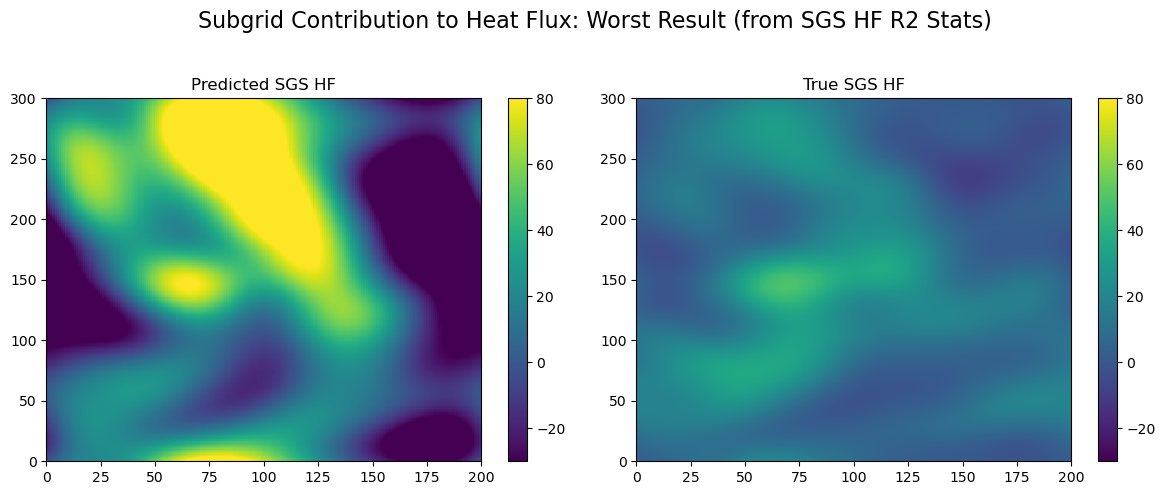

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx)
data2 = HF_SGS_all_true.isel(time=min_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=-30, vmax=80)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=-30, vmax=80)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Best Case Results (from downscaling R2 values)

In [73]:
max_idx_down = 39
min_idx_down = 100

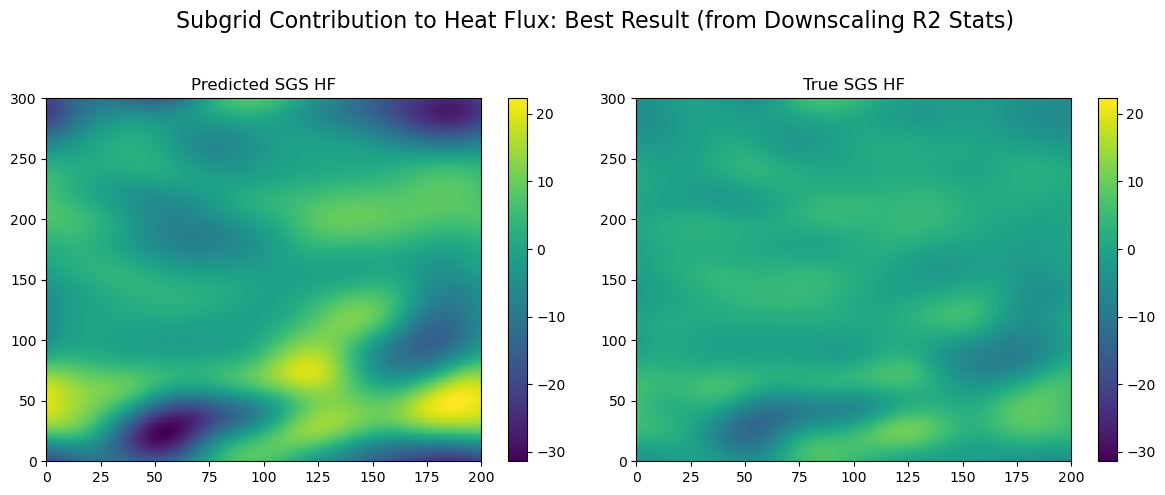

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [85]:
data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
r2(data1.values, data2.values)

0.45661547763215404

## Worst Case Results (from downscaling R2 values)

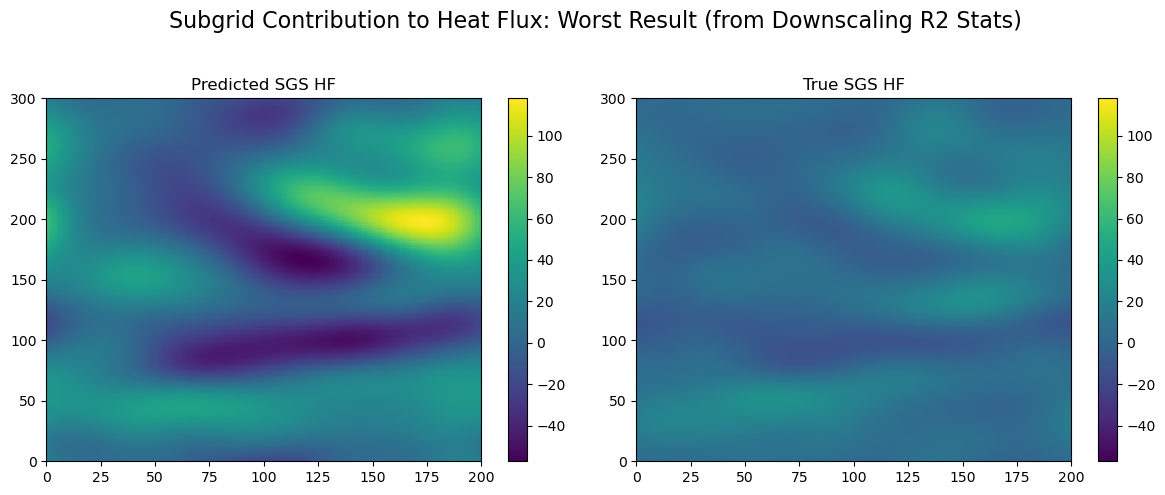

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [84]:
data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
r2(data1.values, data2.values)

0.39726483388721434